# LightGBM-Naive

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [7]:
def compute_forecast(model, forecast_date, horizon, num_samples):

    targets, covariates = load_realtime_training_data(as_of=forecast_date, drop_incomplete=False) 
      
    fct = model.predict(n=horizon, 
                        series=targets, 
                        past_covariates=covariates, 
                        num_samples=num_samples)

    df = reshape_forecast(fct)
    
    return df

In [8]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/{forecast_date}/{forecast_date}-lightgbm-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, forecast_date, HORIZON, NUM_SAMPLES)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/lightgbm_uncorrected/{forecast_date}-icosari-sari-lightgbm_uncorrected.csv', index=False)
        return df
    else:
        return df

In [ ]:
forecasts = []
for forecast_date in FORECAST_DATES:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

# Plot forecasts

In [29]:
df = pd.concat(forecasts)

In [30]:
target_sari = load_target_series('sari')

In [31]:
df_plot = prepare_plot_data(df, target_sari)

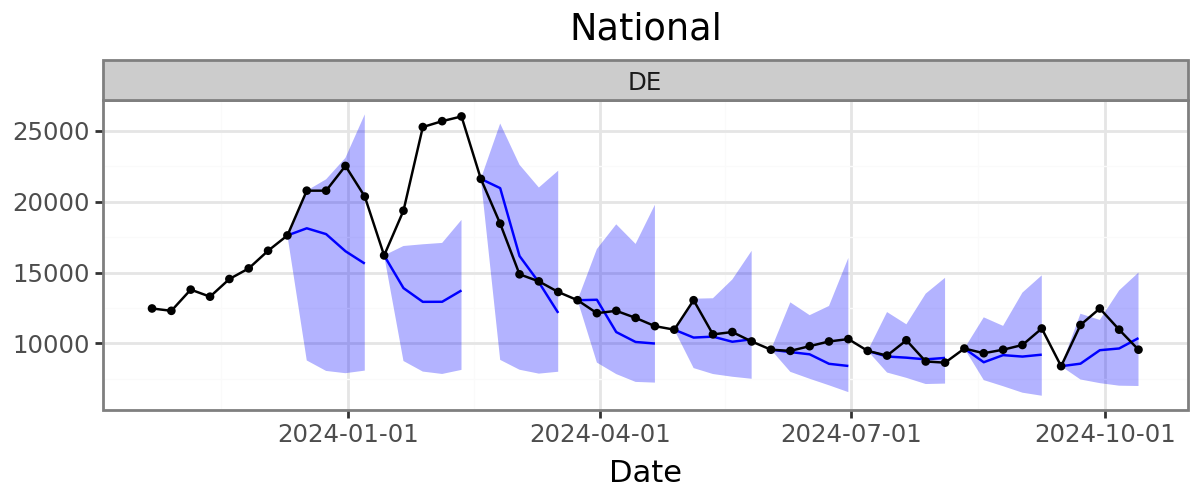

In [32]:
plot_forecasts(df_plot, 'national', start=0)

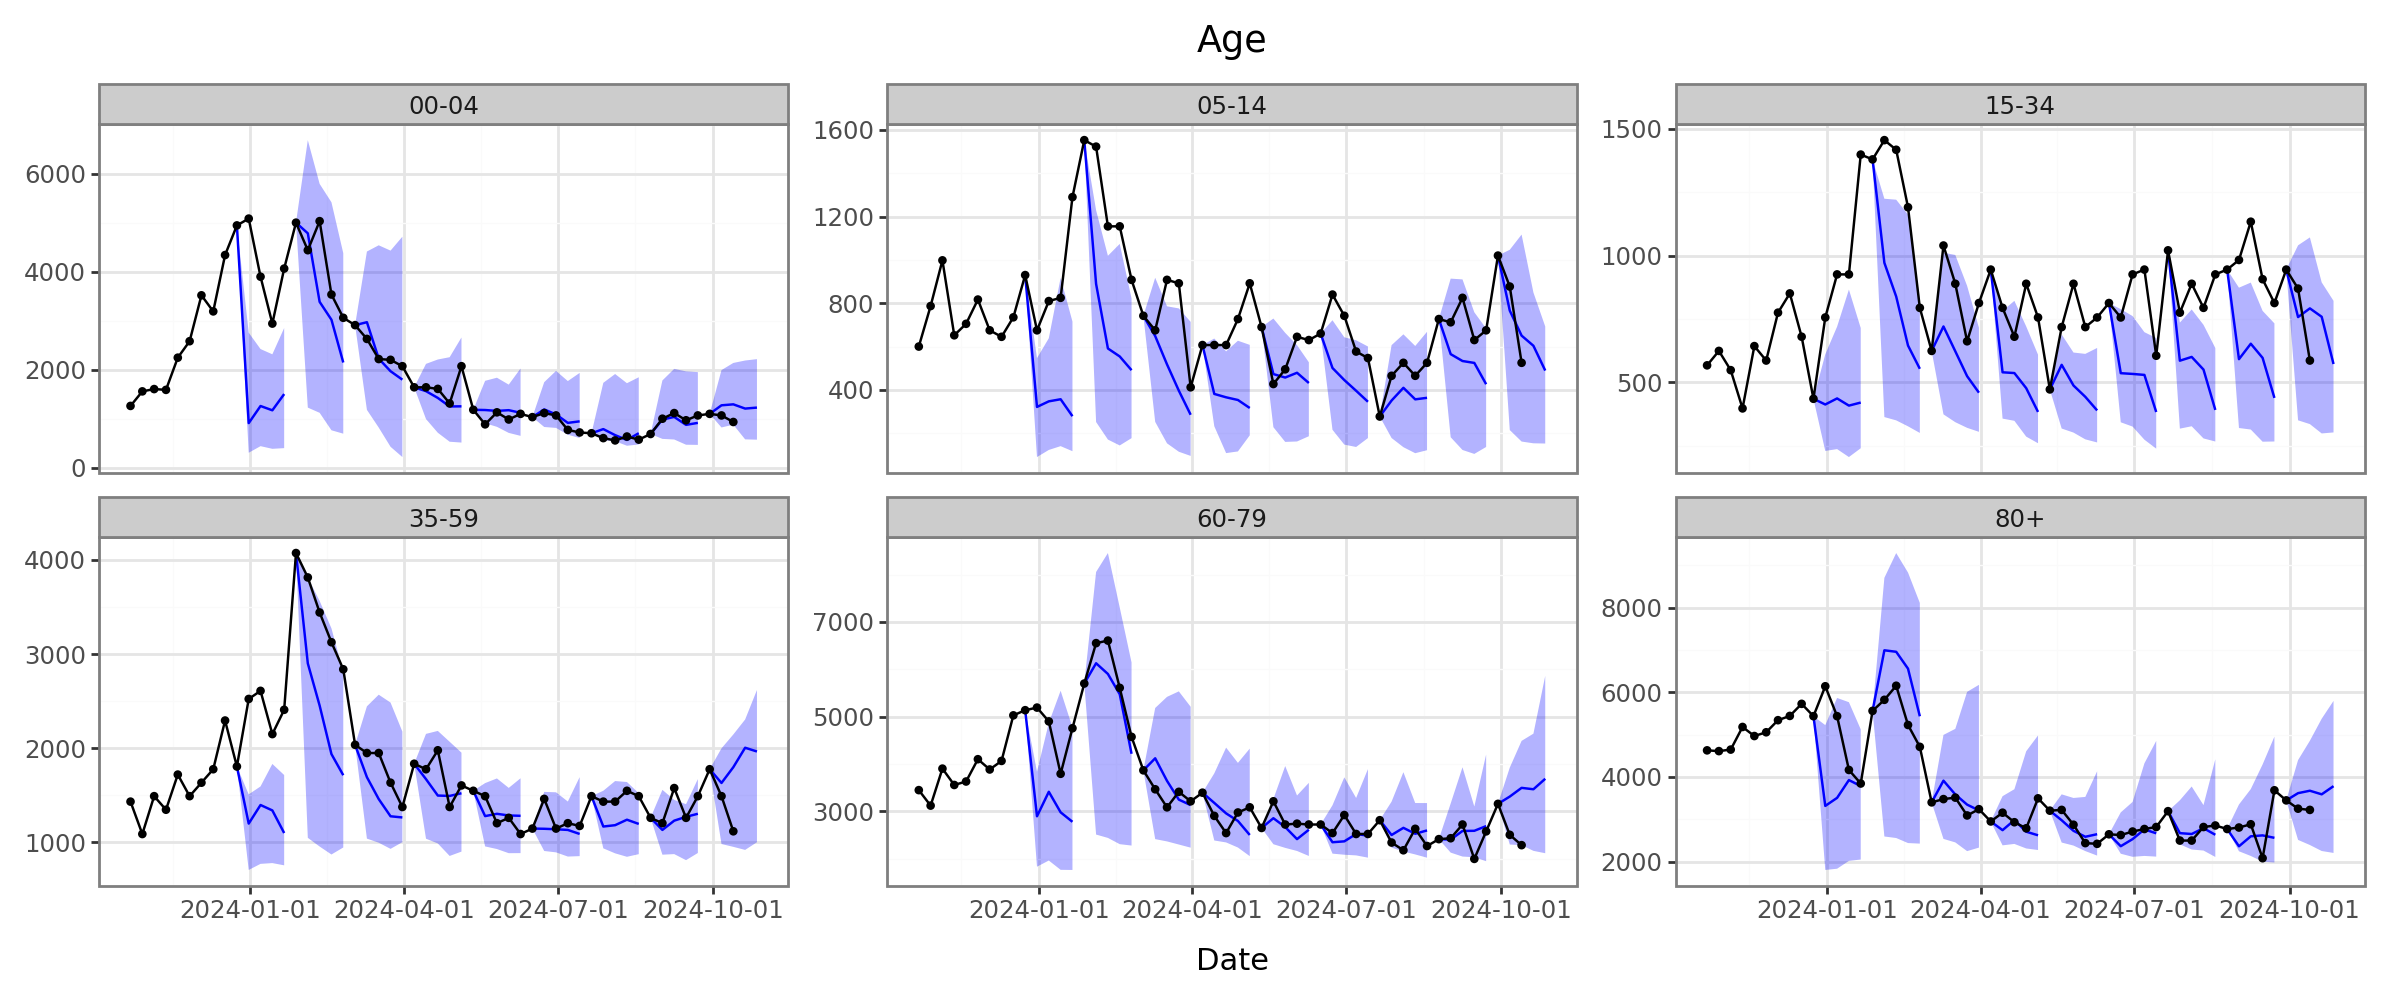

In [37]:
plot_forecasts(df_plot, 'age', start=2)